In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Prepare & explore the data

In [10]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



def create_training_tensors_cifar(directory):
    training_data = []
    training_labels = []
    for i in range (1,6):
        filename = directory + 'data_batch_{}'.format(i)
        dictionary = unpickle(filename)
        
        data = dictionary[b'data']
        data = np.reshape(data, newshape=(10000, 3, 32, 32))
        data = np.swapaxes(data, 1, 3)
        data = np.swapaxes(data, 1, 2)
        training_data.append(data)
        
        labels = dictionary[b'labels']
        training_labels.append(labels)
        
    training_data = np.array(training_data)
    training_data = np.reshape(training_data, newshape=(50000,32,32,3))
    training_labels = np.array(training_labels)
    training_labels = np.reshape(training_labels, newshape=(50000,))
    
    return training_data, training_labels
        
    
def create_validation_tensors_cifar(directory):

    filename = directory + 'test_batch'
    dictionary = unpickle(filename)

    data = dictionary[b'data']
    data = np.reshape(data, newshape=(10000, 3, 32, 32))
    data = np.swapaxes(data, 1, 3)
    data = np.swapaxes(data, 1, 2)
    
    labels = dictionary[b'labels']
    labels = np.array(labels)
    
    return data, labels
               

        
training_data, training_labels = create_training_tensors_cifar('./cifar-10-python/')
validation_data, validation_labels = create_validation_tensors_cifar('./cifar-10-python/')


label_to_word = {
    0: "Airplane",
    1: "Autombile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}


<class 'tuple'>
50000


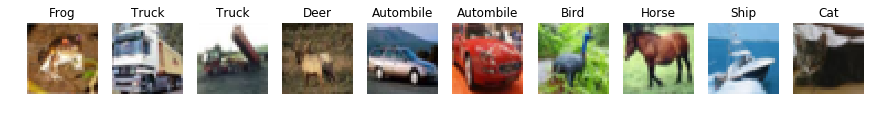

In [28]:
# visualize data
fig, ax = plt.subplots(1,10,figsize=(15,15))
print(type(training_data.shape))
for i in range(10):
    ax[i].imshow(training_data[i])
    ax[i].set_title(label_to_word[training_labels[i]])
    ax[i].axis('off')
print(len(training_data))

In [12]:
# reset graph
tf.reset_default_graph()

# use tf.data library to create a proper dataset that we can work with.
train_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

# directly define batchsize we want to use.
train_batch_size = 200
val_batch_size = 10000
train_dataset = train_dataset.batch(train_batch_size)
val_dataset = val_dataset.batch(val_batch_size)


# Shuffle the training data in each epoch.
num_training = len(training_labels)
train_dataset = train_dataset.shuffle(buffer_size=num_training, reshuffle_each_iteration=True)

In [13]:
# Iterator
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)

print(train_dataset.output_shapes, train_dataset.output_types)

# method that returns always the next element from the iterator.
next_batch = iterator.get_next()

# make initializer operations
train_init_op = iterator.make_initializer(train_dataset)
val_init_op = iterator.make_initializer(val_dataset)

# next_batch returns img & label
input_data = next_batch[0]
labels = next_batch[1]

input_data = tf.cast(input_data, tf.float32)

# make hot encoded labels
num_classes = len(np.unique(training_labels))
labels_hot = tf.one_hot(labels, num_classes)


(TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)]), TensorShape([Dimension(None)])) (tf.uint8, tf.int64)


## 2. Building the Model

In [15]:
# ============================Convolutional Layer 1 ================================================
with tf.variable_scope("conv_layer1"):
    kern_size = 5
    num_kernels = 16
    channels = training_data.shape[3] # RGB, from training_data(num,height,width,channel)
    stride = 1
    
    # initialize random weights of our kernel
    kernels = tf.Variable(tf.truncated_normal([kern_size, kern_size, 
                                               channels, num_kernels], stddev = 0.1))
    print("kernel shape: {}".format(kernels.shape))
    print("input data shape: {}". format(input_data.shape))
    # perform convolution
    convolution = tf.nn.conv2d(input_data, kernels, strides = [1, stride, stride, 1], padding = "SAME")
    
    # initialize biases
    biases = tf.Variable(tf.zeros([num_kernels]))
    feature_maps = tf.nn.tanh(convolution + biases)
    print("feature maps shape: {}".format(feature_maps.shape))
    
    # ==========================Pooling layer 1======================================================
    pkern_size = 2
    pstride = 2
    pooling1 = tf.nn.max_pool(feature_maps,ksize = [1, pkern_size, pkern_size, 1],
                             strides = [1, pstride, pstride, 1], padding = "SAME")
    print("pool1 shape: {}".format(pooling1.shape))
    
# ============================Convolutional Layer 2 ================================================
with tf.variable_scope("conv_layer2"):
    kern_size = 3
    num_kernels = 32
    channels = pooling1.shape[3].value # RGB, from training_data(num,height,width,channel)
    stride = 1
  
    # initialize random weights of our kernel
    kernels = tf.Variable(tf.truncated_normal([kern_size, kern_size, 
                                               channels, num_kernels], stddev = 0.1))
    print("kernel shape: {}".format(kernels.shape))
    # perform convolution
    convolution = tf.nn.conv2d(pooling1, kernels, strides = [1, stride, stride, 1], padding = "SAME")
    
    # initialize biases
    biases = tf.Variable(tf.zeros([num_kernels]))
    feature_maps = tf.nn.tanh(convolution + biases) # why??? 
    
    # ==========================Pooling layer 2======================================================
    pkern_size = 2
    pstride = 2
    pooling2 = tf.nn.max_pool(feature_maps,ksize = [1, pkern_size, pkern_size, 1],
                             strides = [1, pstride, pstride, 1], padding = "SAME")
    
    print(pooling2.shape) # should be 8x8 ??? 

kernel shape: (5, 5, 3, 16)
input data shape: (?, 32, 32, 3)
feature maps shape: (?, 32, 32, 16)
pool1 shape: (?, 16, 16, 16)
kernel shape: (3, 3, 16, 32)
(?, 8, 8, 32)


In [27]:
# ============================ Fully Connected Layer 1 =============================================
with tf.variable_scope("full_layer1"):
    # flatten the output from 2nd pooling layer
    poolshape = pooling2.get_shape().as_list()
    flat_len = np.product(poolshape[1:]) # 8 x 8 x 32 = 2048
    flat_output = tf.reshape(pooling2, shape= [-1, flat_len])
    print(len(pooling2.shape))
    print(len(flat_output.shape))
    
    # initialize weights
    num_neurons = 512
    W = tf.Variable(tf.random_normal([flat_len, num_neurons],stddev=2e-06))
    
    # initialize biases
    B = tf.Variable(tf.zeros([1,num_neurons]))
    
    # calc. drive & output
    drive = tf.matmul(flat_output,W) + B 
    out = tf.nn.tanh(drive)
    print(out.shape)

# ========================== Fully Connected Layer 2 ==============================================
with tf.variable_scope("full_layer2"):
    # init. weights
    num_neurons = 10
    W = tf.Variable(tf.random_normal([out.shape[1].value, num_neurons], stddev=2e-06))
    
    # drive & output
    drive = tf.matmul(out, W)
    out = tf.nn.softmax(drive)
    print(out.shape)

print(out)

4
2
(?, 512)
(?, 10)
Tensor("full_layer2_9/Softmax:0", shape=(?, 10), dtype=float32)


In [168]:
# CROSS-ENTROPY LOSS 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(dim=-1, 
                                                           logits=drive,labels=labels_hot) 
loss = tf.reduce_mean(cross_entropy)

# OPTIMIZER
a = 1e-4 # learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=a)
training_step = optimizer.minimize(loss)

# ACCURACY
labels = tf.cast(labels, tf.float32)
prediction = tf.cast(tf.argmax(input=out, axis=1), tf.float32) # index of most likely class 
correct = tf.cast((tf.equal(prediction, labels)), tf.float32) 
accuracy = tf.reduce_mean(correct) 
print(correct)
print(labels)
print(prediction)

Tensor("Cast_3:0", shape=(?,), dtype=float32)
Tensor("Cast_1:0", shape=(?,), dtype=float32)
Tensor("Cast_2:0", shape=(?,), dtype=float32)


## 3. Training

In [169]:
# Define summaries
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)
mergesum = tf.summary.merge_all()

t_write = tf.summary.FileWriter('./summaries/train')
v_write = tf.summary.FileWriter('./summaries/validation',flush_secs=2)

# ========================== Training & Validation ==========================================
epochs = 5
with tf.Session() as sess:
    
    # initialize the variables.
    sess.run(tf.global_variables_initializer())
    global_step = 0
    
    # loop through epochs
    for _ in range(epochs):
        
        # TRAINING
        # Load the training data into the iterator.
        sess.run(train_init_op)
        
        # In each epoch we want to go through all batches of the training data. 
        while True:
            try:
                _, summary  = sess.run((training_step, mergesum))
                # We write the summary into our folder.
                t_write.add_summary(summary, global_step)

                global_step += 1
                
            # Breakout of the loop if we looked at all batches
            except tf.errors.OutOfRangeError:
                break
            
    # VALIDATION
    # Load the validation data into the iterator.
    sess.run(val_init_op)
    summary = sess.run((mergesum))
    v_write.add_summary(summary, global_step)
